# **STEP 1 - Exploratory Data Analysis**

The goal of this project is to categorize BBC news articles into predefined categories based on the content found within their text. Prior to developing the models needed to reach this goal, it is always important to understand and evaluate the dataset through Exploratory Data Analysis (EDA). The following outlines some of the steps taken, as well as initial findings as we import and examine the datasets.
$$
$$
**Distribution per category**

Being that this is a classification task, it is important to see how news articles are distributed across the five defined news categories (sport, business, politics, entertainment, tech). Through both a numerical count per category, along with visualization by means of a bar chart, it can be seen that there is a fairly balanced distribution over the five categories. It is important to ensure that this balance exists or we might end up training our learning model with bias towards certain categories, thus skewing our predictions.
$$
$$
**Text cleaning**

One of the first steps in cleaning and preparing our dataset is to remove the common English stopwords (eg. “the”, “and”, “it”) since we can assume that they will appear in all articles, but will not add value in determining the label associated with the article. We also remove extra spaces, punctuation, and convert the text to all lowercase. This gives us a more uniform dataset to work with for text classification.
$$
$$
**Text length distribution**

It is also important to see how much variance there is between the lengths of the different text articles that we will be working with. By plotting a histogram of the number of words in each article we can see the distribution of the text lengths, as well as if there are any significant outliers. This information may inform our learning model design and the use of different hyperparameters.
$$
$$
**Word counts per category**

Using another bar chart we can see the average number of words in each article according to its category label. It is important to observe that there are similar average counts amongst the different categories or we may have model bias when trying to capture the unique characteristics of each category.
$$
$$
**Most frequent words**

We can also explore both numerically and visually the words that occur most frequently in our training dataset. The top 20 occurring words along with their counts are shown. Visually, a word cloud chart is shown to highlight this same information.


In [18]:
# Essential libraries
import gdown
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter
import re
import nltk
from nltk.corpus import stopwords
from google.colab import files

# NLP libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD

# Supervised learning libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.utils import resample

# Visualization settings
sns.set(style="whitegrid")

In [2]:
# Use the Google Drive link to download the training set
file_id_train = '1lf_QMbegg22eMi5EGwtglP1EPq08UZae'
download_url_train = f"https://drive.google.com/uc?id={file_id_train}"

# Use the Google Drive link to download the testing set
file_id_test = '1_q37Sjss8dDXTW3Wb557HvFlagDpVk7c'
download_url_test = f"https://drive.google.com/uc?id={file_id_test}"

# Download the training dataset
gdown.download(download_url_train, 'bbc_news_data_train.csv', quiet=False)

# Download the training dataset
gdown.download(download_url_test, 'bbc_news_data_test.csv', quiet=False)

# Load the training and testing dataset
train = pd.read_csv('bbc_news_data_train.csv')
test = pd.read_csv('bbc_news_data_test.csv')

Downloading...
From: https://drive.google.com/uc?id=1lf_QMbegg22eMi5EGwtglP1EPq08UZae
To: /content/bbc_news_data_train.csv
100%|██████████| 3.35M/3.35M [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_q37Sjss8dDXTW3Wb557HvFlagDpVk7c
To: /content/bbc_news_data_test.csv
100%|██████████| 1.71M/1.71M [00:00<00:00, 101MB/s]


In [3]:
print(test.head())
print(test.info())

   ArticleId                                               Text
0       1018  qpr keeper day heads for preston queens park r...
1       1319  software watching while you work software that...
2       1138  d arcy injury adds to ireland woe gordon d arc...
3        459  india s reliance family feud heats up the ongo...
4       1020  boro suffer morrison injury blow middlesbrough...
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 735 entries, 0 to 734
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  735 non-null    int64 
 1   Text       735 non-null    object
dtypes: int64(1), object(1)
memory usage: 11.6+ KB
None


In [4]:
# Inspect the training dataset
print(train.head())
print(train.info())
print(train.describe())

   ArticleId                                               Text  Category
0       1833  worldcom ex-boss launches defence lawyers defe...  business
1        154  german business confidence slides german busin...  business
2       1101  bbc poll indicates economic gloom citizens in ...  business
3       1976  lifestyle  governs mobile choice  faster  bett...      tech
4        917  enron bosses in $168m payout eighteen former e...  business
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1490 entries, 0 to 1489
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ArticleId  1490 non-null   int64 
 1   Text       1490 non-null   object
 2   Category   1490 non-null   object
dtypes: int64(1), object(2)
memory usage: 35.0+ KB
None
         ArticleId
count  1490.000000
mean   1119.696644
std     641.826283
min       2.000000
25%     565.250000
50%    1112.500000
75%    1680.750000
max    2224.000000


In [5]:
# Check for number of articles per category
print(train['Category'].value_counts())

Category
sport            346
business         336
politics         274
entertainment    273
tech             261
Name: count, dtype: int64


In [6]:
# Check for missing values
print(train.isnull().sum())

ArticleId    0
Text         0
Category     0
dtype: int64


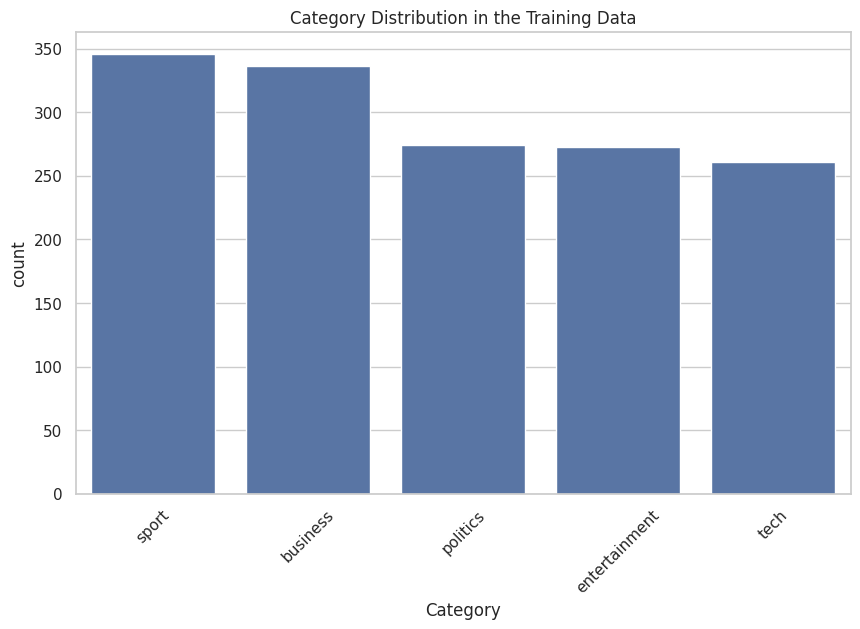

In [7]:
# Bar plot for category distribution
plt.figure(figsize=(10, 6))
sns.countplot(data=train, x='Category', order=train['Category'].value_counts().index)
plt.title("Category Distribution in the Training Data")
plt.xticks(rotation=45)
plt.show()

In [8]:
# Download stopwords
nltk.download('stopwords')

# Define cleaning function
def clean_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove all non-word characters
    text = re.sub(r'\s+', ' ', text)  # Replace multiple spaces with a single space
    text = text.lower()  # Convert to lowercase
    return text

# Apply the cleaning function to the training set
train['cleaned_text'] = train['Text'].apply(clean_text)
# Apply the cleaning function to the testing set
test['cleaned_text'] = test['Text'].apply(clean_text)

# Remove stopwords from both training and testing set
stop_words = set(stopwords.words('english'))
train['cleaned_text'] = train['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))
test['cleaned_text'] = test['cleaned_text'].apply(lambda x: ' '.join([word for word in x.split() if word not in stop_words]))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


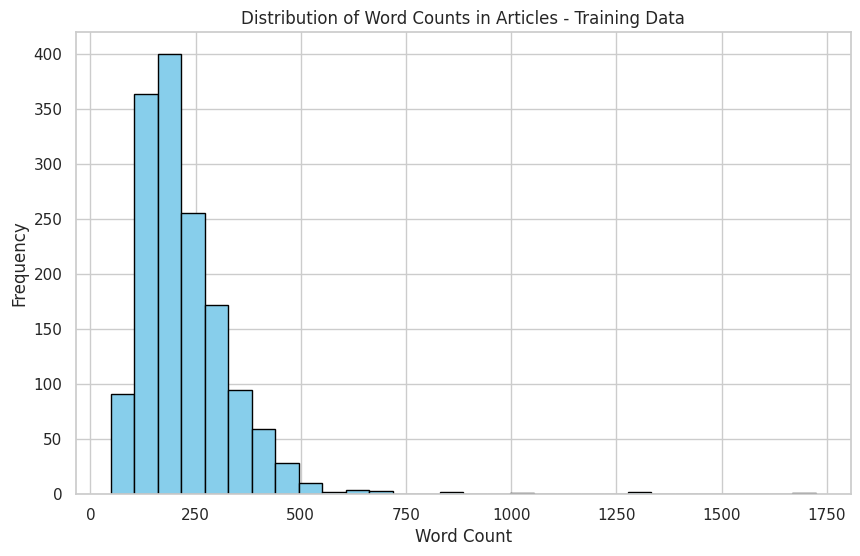

In [9]:
# Add a column for word count in training set
train['word_count'] = train['cleaned_text'].apply(lambda x: len(x.split()))

# Histogram for word count distribution
plt.figure(figsize=(10, 6))
plt.hist(train['word_count'], bins=30, color='skyblue', edgecolor='black')
plt.title("Distribution of Word Counts in Articles - Training Data")
plt.xlabel("Word Count")
plt.ylabel("Frequency")
plt.show()

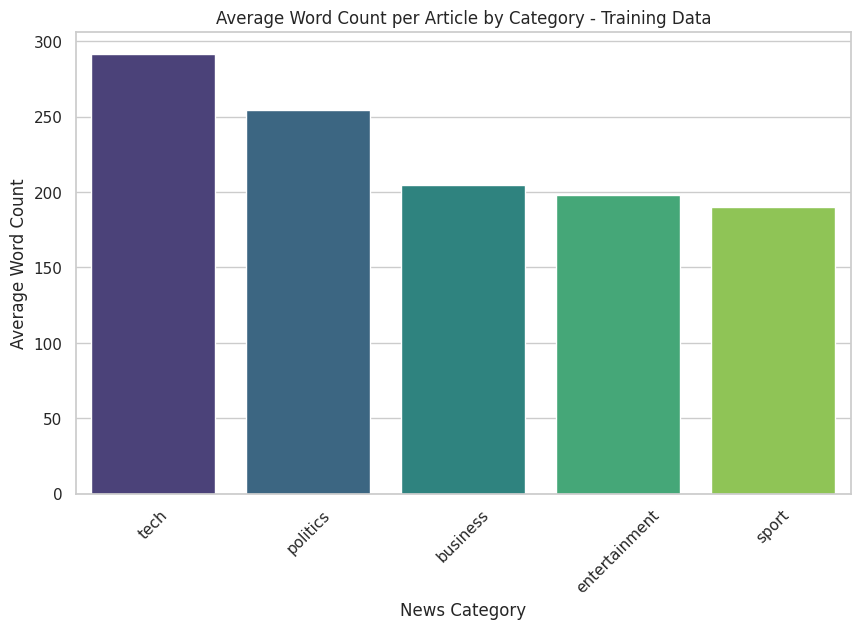

In [10]:
# Group training set by category and calculate the average word count
category_word_count = train.groupby('Category')['word_count'].mean().reset_index()

# Sort the values by average word count
category_word_count = category_word_count.sort_values(by='word_count', ascending=False)

# Plot the average word count per category
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='word_count', hue='Category', data=category_word_count, palette='viridis')
plt.title('Average Word Count per Article by Category - Training Data')
plt.xlabel('News Category')
plt.ylabel('Average Word Count')
plt.xticks(rotation=45)
plt.show()

In [11]:
# Flatten the list of words for all articles training set
all_words = [word for article in train['cleaned_text'] for word in article.split()]

# Count the frequency of each word
word_freq = Counter(all_words)

# Get the 20 most common words
most_common_words = word_freq.most_common(20)

# Print the top 20 words and their frequencies from the training set
print("Top 20 Most Frequent Words:")
for word, freq in most_common_words:
    print(f"{word}: {freq}")

Top 20 Most Frequent Words:
said: 4839
mr: 1974
would: 1714
year: 1528
also: 1426
new: 1338
people: 1324
us: 1264
one: 1245
could: 1032
first: 934
last: 893
two: 889
time: 882
world: 805
uk: 781
government: 752
film: 646
years: 644
best: 642


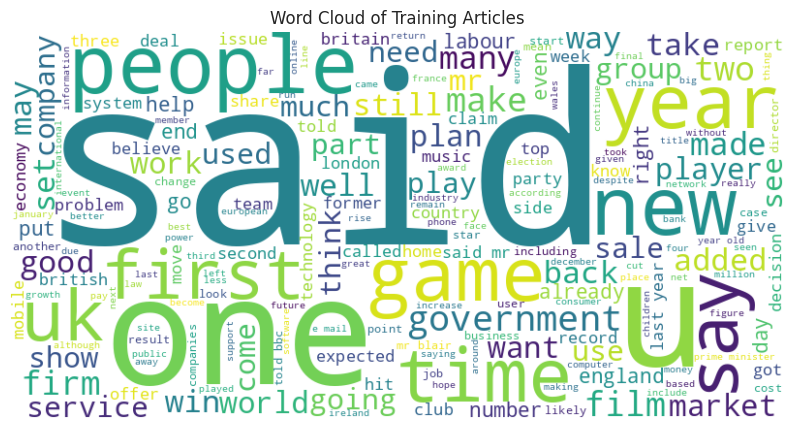

In [12]:
# Generate a word cloud for cleaned text in the training set
text_combined = ' '.join(train['cleaned_text'].values)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Training Articles")
plt.show()

In [13]:
# Calculate the number of unique words in the cleaned training text
unique_words = len(set([word for article in train['cleaned_text'] for word in article.split()]))
print(f"Total number of unique words: {unique_words}")

Total number of unique words: 24636


# Choice of Term Frequency - Inverse Document Frequency (TF-IDF)

For this project we will use the Term Frequency - Inverse Document Frequency (TF-IDF) method to convert the raw text of the articles into numerical features in matrix form. This allows us to process the text for classification and prediction. The TF-IDF method is used to compare the importance of a word in a text relative to all of the other texts. It uses the concept of Term Frequency - the number of instances of a given word - and the Inverse Document Frequency  - the inverse of the frequency of occurrence of a word in the entire corpus of the dataset. The less common a word is across all articles, the higher the weight given to it in the matrix.

We can see this method given by the following formulas:
$$
$$


$$
\text{TF}(t, d) = \frac{\text{Count of term } t \text{ in document } d}{\text{Total terms in document } d}
$$
\
$$
\text{IDF}(t) = \log\left(\frac{\text{Total number of documents}}{\text{Number of documents containing term } t}\right)
$$
\
$$
\text{TF-IDF}(t, d) = \text{TF}(t, d) \times \text{IDF}(t)
$$
\
The TF-IDF method makes sense for creating models with our dataset for the following reasons:
$$
$$
**Focuses on the importance of the words**

This method not only looks at the frequency of each word, but also penalizes words that are common across all of the articles. In doing so we are focusing specifically on the words that are unique to the category in question, leading to more effective classification.
$$
$$
**Easy integration with learning models**

We will be analyzing the dataset from both an unsupervised and supervised approach, and the TF-IDF method integrates well with each. In doing so we can easily integrate different algorithms with the same TF-IDF matrix.
$$
$$
**Sparse representation**

The TF-IDF method generates a sparse matrix with each article being represented as a vector, and each dimension corresponding to a word. This is an efficient format both in terms of memory usage and computational complexity. This is an efficient method for working with the high dimensional data found in news articles.
$$
$$
**Easy interpretation**

Compared with some of the other methods available for word embedding, the TF-IDF method is easy to interpret. Each word is given a score based on its importance, which allows us to clearly understand how the models might make predictions.


# Plan of Analysis
Based on our EDA findings, we will use the following plan for analysis:
$$
$$
**Text Preprocessing**

As mentioned above the text will be cleaned by converting all to lowercase, removing punctuation, and removing stopwords. This helps to ensure that the text is normalized and ready for us to apply feature extraction using the TF-IDF method.
$$
$$
**Feature Extraction with TF-IDF**

Using the TF-IDF method we will convert the cleaned text into a numerical matrix, representing each article as a sparse vector of TF-IDF scores. This method assigns a higher weight to words that appear frequently in a particular article, but rarely across all articles.
$$
$$
**Non-negative Matrix Factorization (Unsupervised Learning Model)**

In order to discover hidden topics or patterns in the news articles, we will build an unsupervised learning model using Nonnegative Matrix Factorization (NMF). The NMF model will reduce the dimensionality of the TF-IDF matrix to a set of topic components, which may be interpreted and used to predict labels for future news articles.
$$
$$
**Comparison With Logistic Regression (Supervised Learning Model)**

The NMF model will be compared with logistic regression models to see how accuracy changes with the implementation of supervised learning models. Different percentages of the training set can be used to observe changes in accuracy and efficiency. We can also adjust hyperparameters related to both types of models to see the effects caused by different variables.


In [14]:
# Initialize TF-IDF Vectorizer
tfidf = TfidfVectorizer()

# Fit and transform the cleaned text traing set
X_train = tfidf.fit_transform(train['cleaned_text'])
X_test = tfidf.transform(test['cleaned_text'])

# The labels
y_train = train['Category']

In [15]:
print(X_test.shape)

(735, 24608)


# **STEP 2 - Model Building and Training**

In the lectures for this class we were presented with two common matrix factorization techniques - Single Value Decomposition (SVD) and Nonnegative Matrix Factorization (NMF). Both are powerful tools as Unsupervised Learning Models and both have their areas of application. In this case we will use the NMF model based on the dataset that we are processing and for the following reasons:
$$
$$
**Non-negativity constraint**

The topic matrix that is developed by factorization is only allowed to have nonnegative values, and the topics are composed of positive word weights. This is in contrast to SVD which does allow both positive and negative values. In the context of natural language processing it is more intuitive that a word may either contribute positively to a topic or not, but it makes less sense for it to ‘anti-contribute’ through a negative value.
$$
$$
**Interpretability**

Although SVD does a great job of capturing variance in the dataset, the fact that each topic is a linear combination of only positive words leads to a result that is more interpretable using the NMF model.
$$
$$
**Suitability of data type**

The NMF model does a better job with non-negative types of data (language, images, audio, etc.), where cases of negative values are not meaningful. Compared with SVD, it also works better with sparse matrices, like the ones produced by the TF-IDF method that we have chosen to use.
$$
$$
**Sparsity**

SVD does an efficient job of reducing dimensionality of the dataset, it does not necessarily lead to sparse solutions. In contrast, NMF usually results in each document associated with only a small number of topics, and each topic with only a small number of words. These sparse solutions are easier to interpret for determining results.
$$
$$
**Context**

NMF is well-suited for tasks like text mining and topic modeling, where interpretability is crucial. Given the need to clearly understand the hidden topics in our dataset, NMF is more appropriate than SVD for this task.


**When you train the unsupervised model for matrix factorization, should you include texts (word features) from the test dataset or not as the input matrix? Why or why not?**
$$
$$
It is not a good practice to include the test dataset when training an unsupervised model for matrix factorization. The purpose of the test dataset is to evaluate how effective our model is generalizing and predicting based on unseen data. If we include the test data when the model is ‘learning’ we create a situation where data leakage is occurring. The model can inadvertently ‘cheat’ by learning from data to which it is supposed to remain blind during testing, using relationships in the test dataset to learn patterns or topics. By excluding the test data we can reliably evaluate the model for its accuracy and performance.

Using an initial NMF model we can see how well it does at predicting the category labels using the training dataset. The accuracy is shown as well as a confusion matrix to show the model's performance.

Train Accuracy: 0.9322147651006711


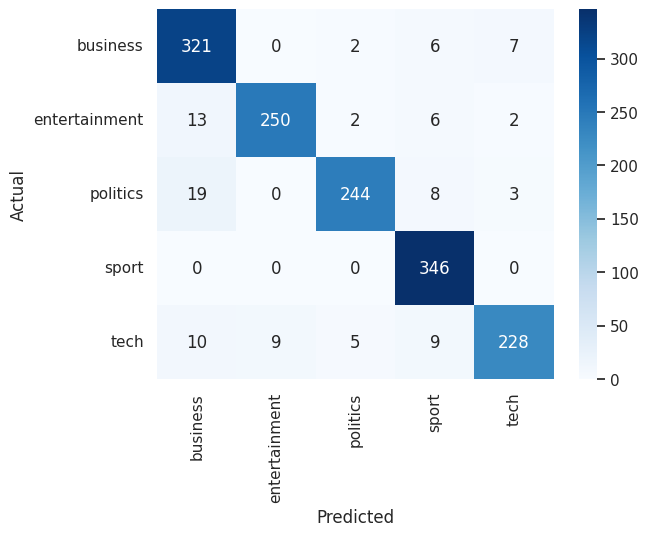

In [16]:
# Initialize the NMF model using n_components = 10 and init = nndsvd
nmf = NMF(n_components=10, random_state=42, init='nndsvd')

# Fit NMF on training data and transform it
X_train_nmf = nmf.fit_transform(X_train)

# Transform the test set using the fitted NMF model
X_test_nmf = nmf.transform(X_test)

# Train a classifier on the transformed training data
clf = LogisticRegression(random_state=42)
clf.fit(X_train_nmf, y_train)

# Predict on the training datasets
y_train_pred = clf.predict(X_train_nmf)

# Measure accuracy on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy}")

# Create confusion matrix of training data showing actual labels vs predicted labels
conf_matrix = confusion_matrix(y_train, y_train_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

We can now test our NMF model while varying two of the hyperparameters - 'n_components' and 'init' - to see how these variations affect the accuracy of the category predictions. The code downloads a separate .csv file for each configuration and the accuracy results are shown after submitting the files to the Kaggle competition.

In [19]:

# List of parameter configurations to test varying n_components and init
param_configs = [
    {'n_components': 5, 'init': 'random'},
    {'n_components': 10, 'init': 'random'},
    {'n_components': 15, 'init': 'random'},
    {'n_components': 5, 'init': 'nndsvd'},
    {'n_components': 10, 'init': 'nndsvd'},
    {'n_components': 15, 'init': 'nndsvd'}
]

for params in param_configs:
    # Initialize NMF with the specific configuration
    nmf_model = NMF(n_components=params['n_components'], init=params['init'], random_state=42)

    # Fit and transform the training data
    X_train_nmf = nmf_model.fit_transform(X_train)

    # Fit the classifier
    classifier = LogisticRegression(max_iter=200, random_state=42)
    classifier.fit(X_train_nmf, y_train)

    # Transform the test set
    X_test_nmf = nmf_model.transform(X_test)

    # Predict
    y_test_pred = classifier.predict(X_test_nmf)

    # Prepare submission
    submission_df = pd.DataFrame({
        'ArticleId': test['ArticleId'].values,
        'Category': y_test_pred
    })

    # Save to CSV file with a name including the hyperparameters
    submission_filename = f'submission_nmf_{params["n_components"]}_{params["init"]}.csv'
    submission_df.to_csv(submission_filename, index=False)

    # Download the submission file
    files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

/usr/local/lib/python3.10/dist-packages/sklearn/decomposition/_nmf.py:1759: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

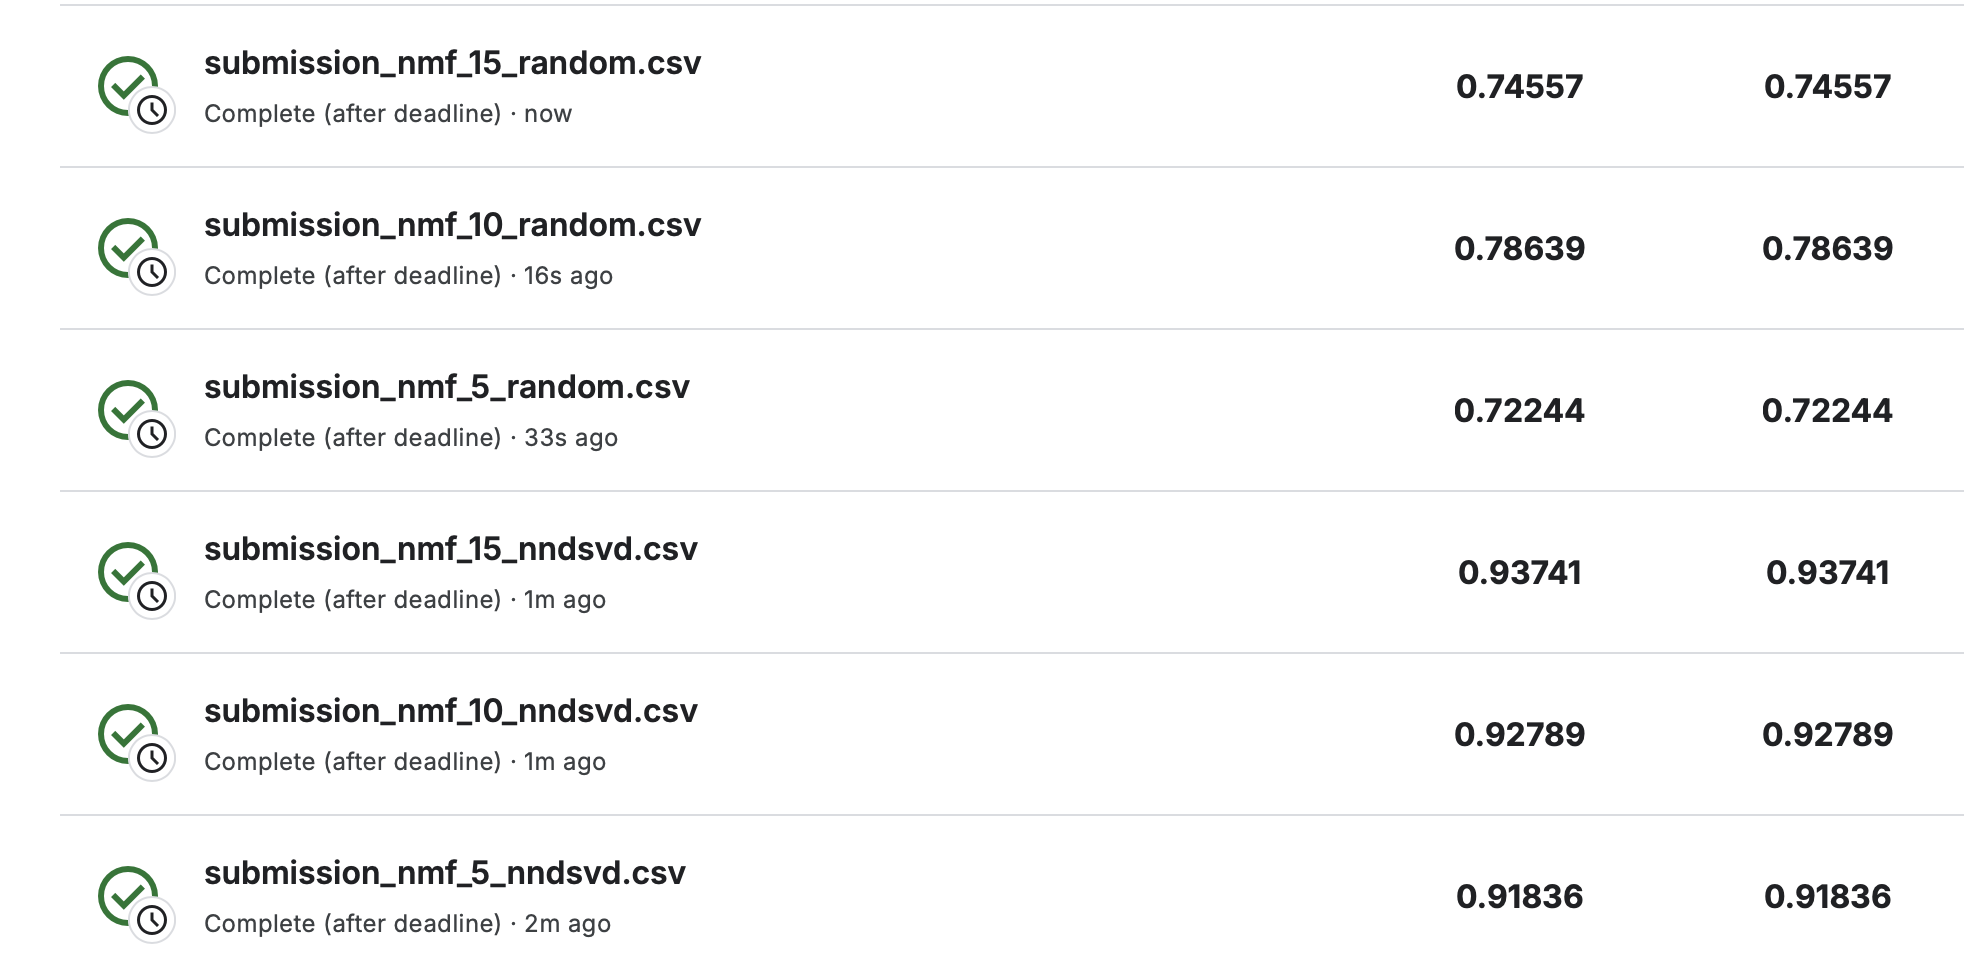

It can be seen form the results that the best accuracy is found using a combination of n_components = 15 and init = nndsvd. This may be the result of an adequate topic count and effective intialization method, but other combinations of hyperparameters, including beta_loss, alpha_W, alpha_H, and solver could be explored to see if there are better, more accurate configurations.

# **STEP 3 - Compare with Supervised Learning Model**

To begin our comparison with a supervised learning model, we will perform a logistic regression on the training dataset. Provided is the accuracy value for predicting the training labels as well as a confusion matrix to show the relationship between actual and predicted labels. The model performs exceptionally well on the training data, which could be due to overfitting of the training data. The model may be learning the data too well, including outliers and noise. Possibly the model is too complex relative to the amount of training data.

Train Accuracy: 0.9979865771812081


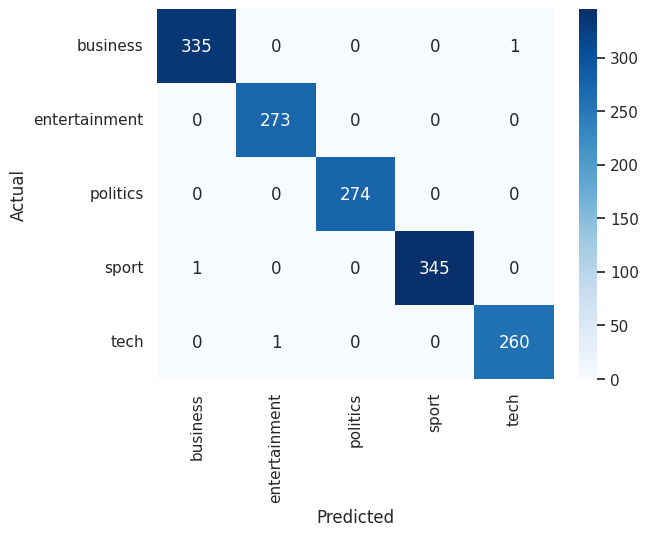

In [20]:
# Initialize and train a logisitic regression model (supervised learning)
clf = LogisticRegression(max_iter=200, random_state=42)
clf.fit(X_train, y_train)

# Predict on the training dataset
y_train_pred_lr = clf.predict(X_train)

# Measure accuracy on training data
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print(f"Train Accuracy: {train_accuracy_lr}")

# Create confusion Matrix
conf_matrix = confusion_matrix(y_train, y_train_pred_lr)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=np.unique(y_train), yticklabels=np.unique(y_train))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Next we will examine the predicting results using the Kaggle evaluation of accuracy, sampling different percentages of the training data to create our model. The evaluation results for accuracy along with a plot of the change in model accuracy as a function of percentage sampled is shown.

In [21]:
# Set percentage of dataset sample sizes
train_sizes = [0.1, 0.2, 0.5, 0.75, 1.0]

for size in train_sizes:
    # Sample the training data
    sampled_indices = np.random.choice(X_train.shape[0], size=int(size * X_train.shape[0]), replace=False)

    # Convert the sampled indices to a sparse matrix format
    X_sampled = X_train[sampled_indices, :]
    y_sampled = y_train.iloc[sampled_indices]

    # Train the model on the sampled data
    clf.fit(X_sampled, y_sampled)

    # Predict on the test set
    y_test_pred = clf.predict(X_test)

    # Prepare submission DataFrame
    submission_df = pd.DataFrame({
        'ArticleId': test['ArticleId'].values,
        'Category': y_test_pred
    })

    # Save to CSV file with a name including the sample size
    submission_filename = f'submission_logistic_regression_{int(size * 100)}percent.csv'
    submission_df.to_csv(submission_filename, index=False)

    # Download the submission file
    files.download(submission_filename)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

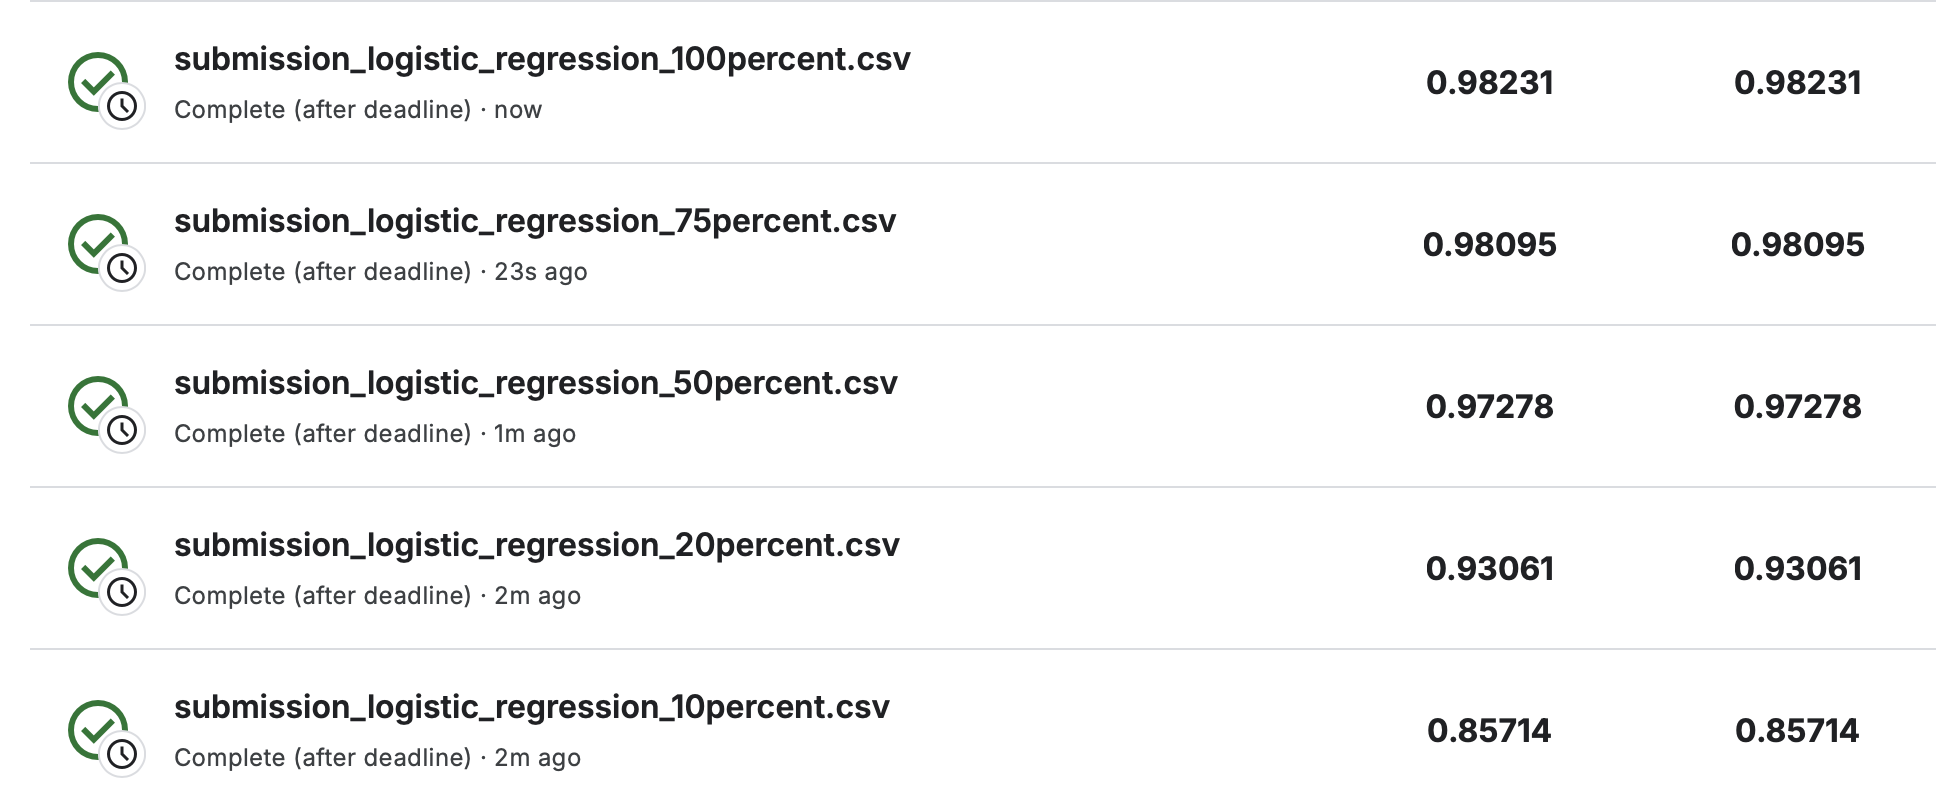

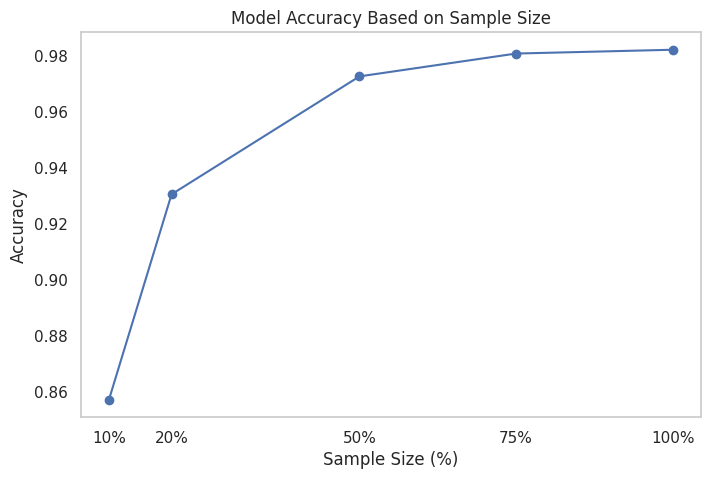

In [22]:
# Sample sizes and corresponding accuracies from Kaggle competition
sample_sizes = [0.1, 0.2, 0.5, 0.75, 1.0]
accuracies = [0.85714, 0.93061, 0.97278, 0.98095, 0.98231]

# Create the plot
plt.figure(figsize=(8, 5))
plt.plot(sample_sizes, accuracies, marker='o')

# Set labels and title
plt.xlabel('Sample Size (%)')
plt.ylabel('Accuracy')
plt.title('Model Accuracy Based on Sample Size')
plt.xticks(sample_sizes, [f"{int(size * 100)}%" for size in sample_sizes])
plt.grid()

# Show the plot
plt.show()

Overall, we can conclude that while both models performed well—especially with hyperparameter tuning for the NMF model—the logistic regression model was more accurate in predicting labels on the testing dataset. Several factors may explain this better performance:
$$
$$
**Supervised vs. Unsupervised Learning**

Logistic regression directly learns from the labeled data, making it more effective when labels are available and the relationship between features and labels is relatively linear and simple. In contrast, the unsupervised NMF model identifies latent patterns, but these patterns may not align perfectly with the actual class labels, affecting classification accuracy.
$$
$$
**Dataset Simplicity**

The simplicity of the dataset may favor logistic regression. Evaluating the articles through NMF might introduce complexity by reducing the dimensionality, potentially losing some important information needed for accurate classification. In such cases, the additional complexity may hinder predictive performance.
$$
$$
**Optimization for Classification**

Logistic regression is inherently optimized for classification through its cost function, which aims to reduce classification error. On the other hand, NMF focuses on minimizing the reconstruction error of the data matrix, which doesn’t directly optimize for classification accuracy.


# **References**

https://medium.com/@abhishekjainindore24/tf-idf-in-nlp-term-frequency-inverse-document-frequency-e05b65932f1d
$$
$$
https://www.geeksforgeeks.org/understanding-tf-idf-term-frequency-inverse-document-frequency/
$$
$$
https://scikit-learn.org/dev/modules/generated/sklearn.decomposition.NMF.html